# Seismic data EDA and baseline

Based on the kernel from https://www.kaggle.com/artgor/seismic-data-eda-and-baseline

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV
import gc
from catboost import CatBoostRegressor
import seaborn as sns
import warnings

from utils import freq_from_crossings, freq_from_fft

In [2]:
%%time
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
fs = 4000000

CPU times: user 1min 17s, sys: 3.49 s, total: 1min 21s
Wall time: 1min 21s


In [3]:
train.head()

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


In [4]:
train.shape

(629145480, 2)

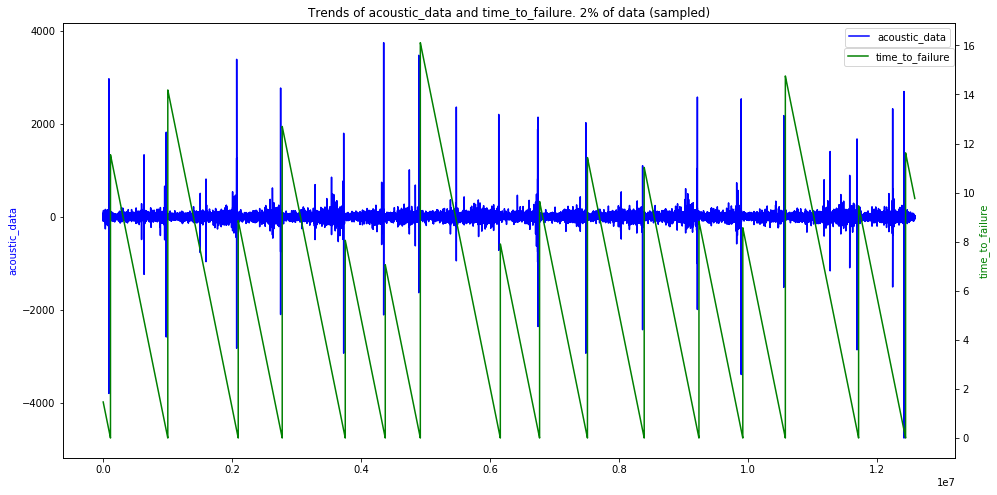

In [5]:
train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

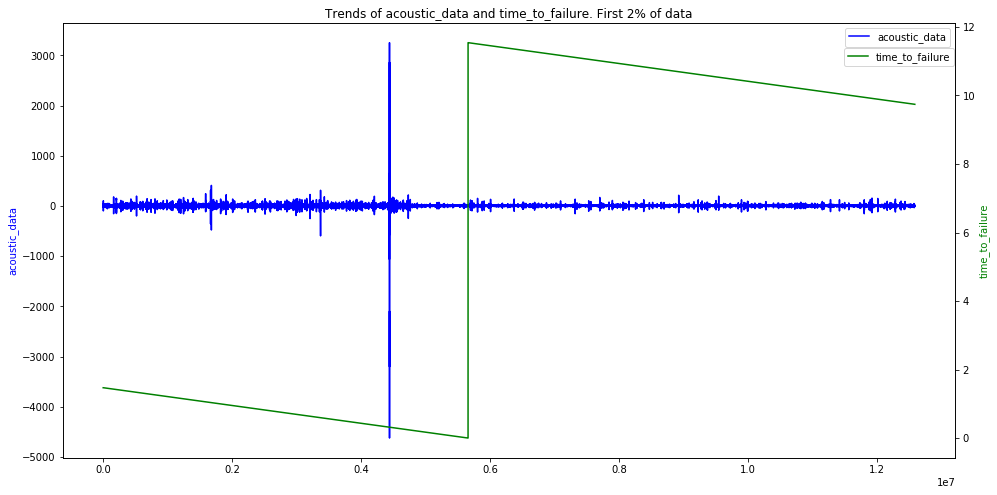

In [6]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. First 2% of data")
plt.plot(train['acoustic_data'].values[:12582910], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train['time_to_failure'].values[:12582910], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

In [7]:
# Create a training file with simple derived features
# TODO: Shall we split also the earthquackes?
# TODO: Where is the division by zero?
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

X_tr = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min',
                               'av_change_abs', 'av_change_rate', 'abs_max', 'abs_min',
                               'std_first_50000', 'std_last_50000', 'std_first_10000', 'std_last_10000',
                               'avg_first_50000', 'avg_last_50000', 'avg_first_10000', 'avg_last_10000',
                               'min_first_50000', 'min_last_50000', 'min_first_10000', 'min_last_10000',
                               'max_first_50000', 'max_last_50000', 'max_first_10000', 'max_last_10000',
                               'freq_cross_first_50000', 'freq_cross_last_50000', 'freq_cross_first_10000', 'freq_cross_last_10000'])
y_tr = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

total_mean = train['acoustic_data'].mean()
total_std = train['acoustic_data'].std()
total_max = train['acoustic_data'].max()
total_min = train['acoustic_data'].min()
total_sum = train['acoustic_data'].sum()
total_abs_max = np.abs(train['acoustic_data']).sum()

for segment in tqdm_notebook(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    y_tr.loc[segment, 'time_to_failure'] = y
    X_tr.loc[segment, 'ave'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
    
    X_tr.loc[segment, 'av_change_abs'] = np.mean(np.abs(np.diff(x)))
    X_tr.loc[segment, 'av_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    X_tr.loc[segment, 'abs_max'] = np.abs(x).max()
    X_tr.loc[segment, 'abs_min'] = np.abs(x).min()
    
    X_tr.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_tr.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_tr.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_tr.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X_tr.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_tr.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_tr.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_tr.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X_tr.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_tr.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_tr.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_tr.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X_tr.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_tr.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_tr.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_tr.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    X_tr.loc[segment, 'freq_cross_first_50000'] = freq_from_crossings(x[:50000], fs)
    X_tr.loc[segment, 'freq_cross_last_50000'] = freq_from_crossings(x[-50000:], fs)
    X_tr.loc[segment, 'freq_cross_first_10000'] = freq_from_crossings(x[:10000], fs)
    X_tr.loc[segment, 'freq_cross_last_10000'] = freq_from_crossings(x[-10000:], fs)

HBox(children=(IntProgress(value=0, max=4194), HTML(value='')))

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


In [8]:
print(f'{X_tr.shape[0]} samples in new train data.')

4194 samples in new train data.


In [9]:
X_tr.columns.size

28

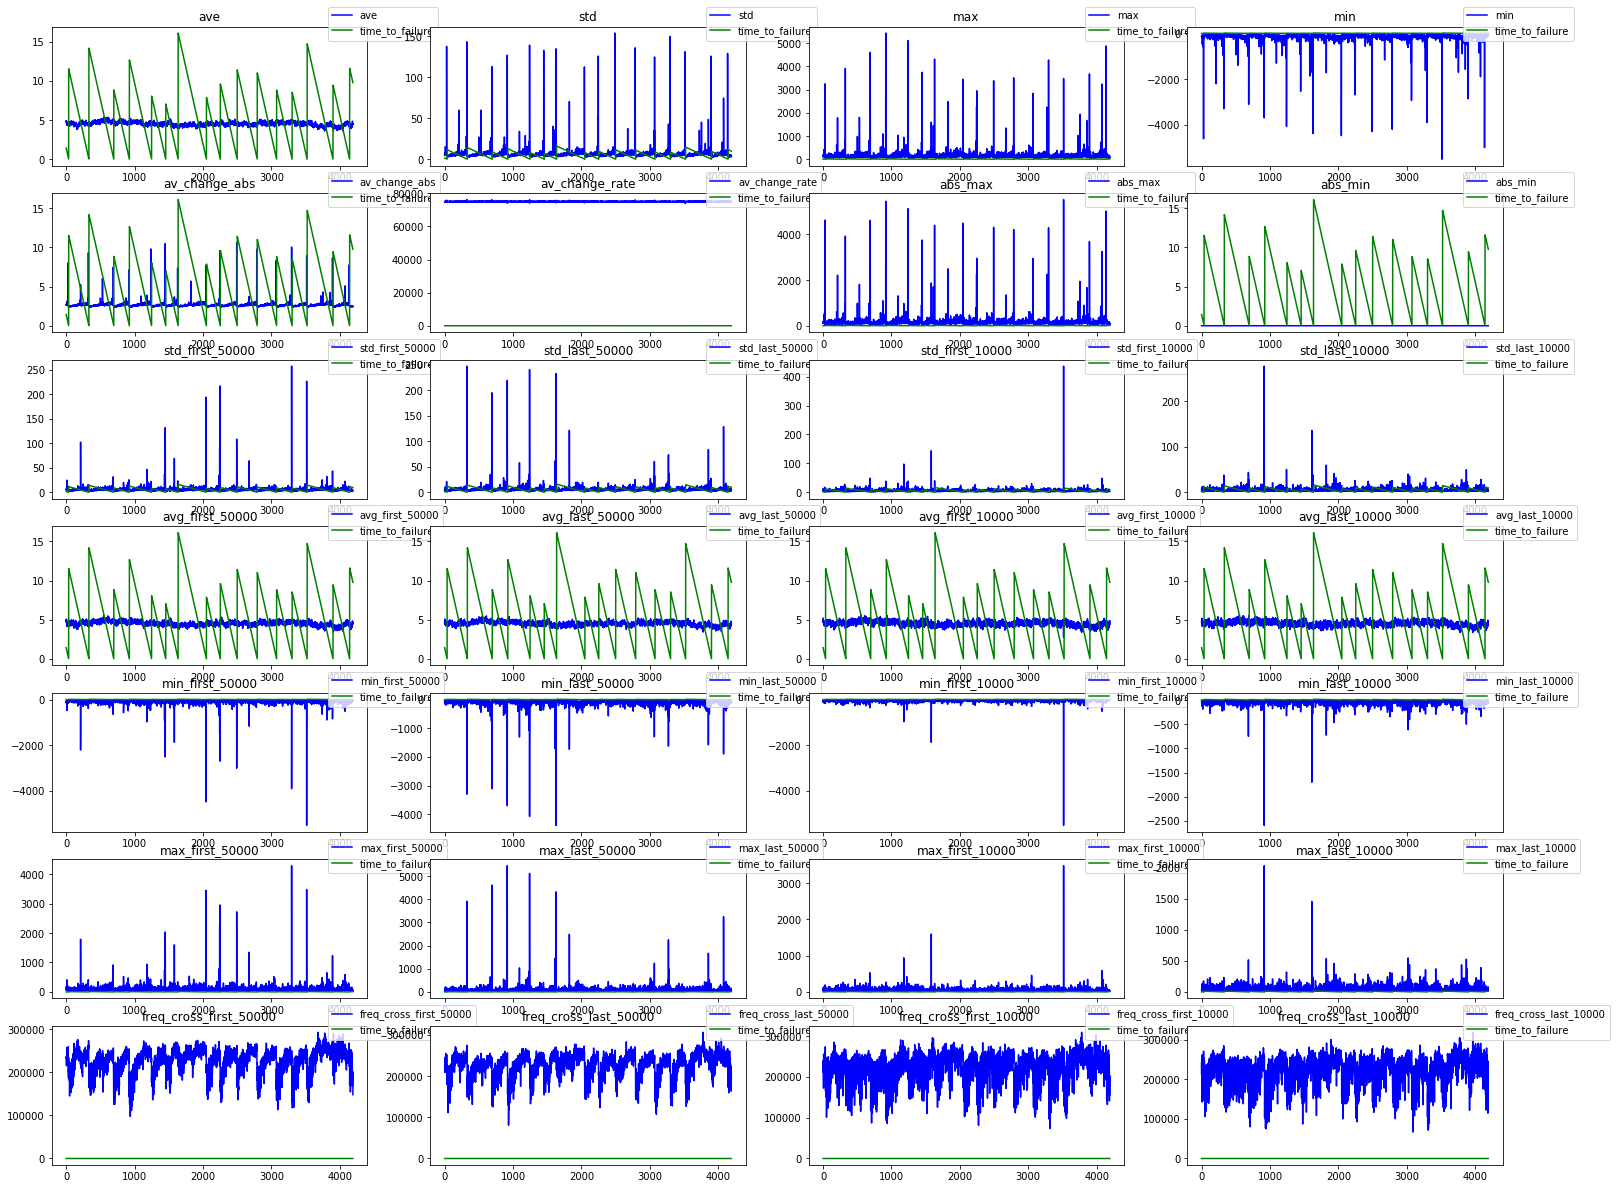

In [10]:
plt.figure(figsize=(26, 24))
for i, col in enumerate(X_tr.columns):
    plt.subplot(8, 4, i + 1)
    plt.plot(X_tr[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')

    ax2 = ax1.twinx()
    plt.plot(y_tr, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend([col, 'time_to_failure'], loc=(0.875, 0.9))
    plt.grid(False)

In [11]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)

HBox(children=(IntProgress(value=0, max=2624), HTML(value='')))

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


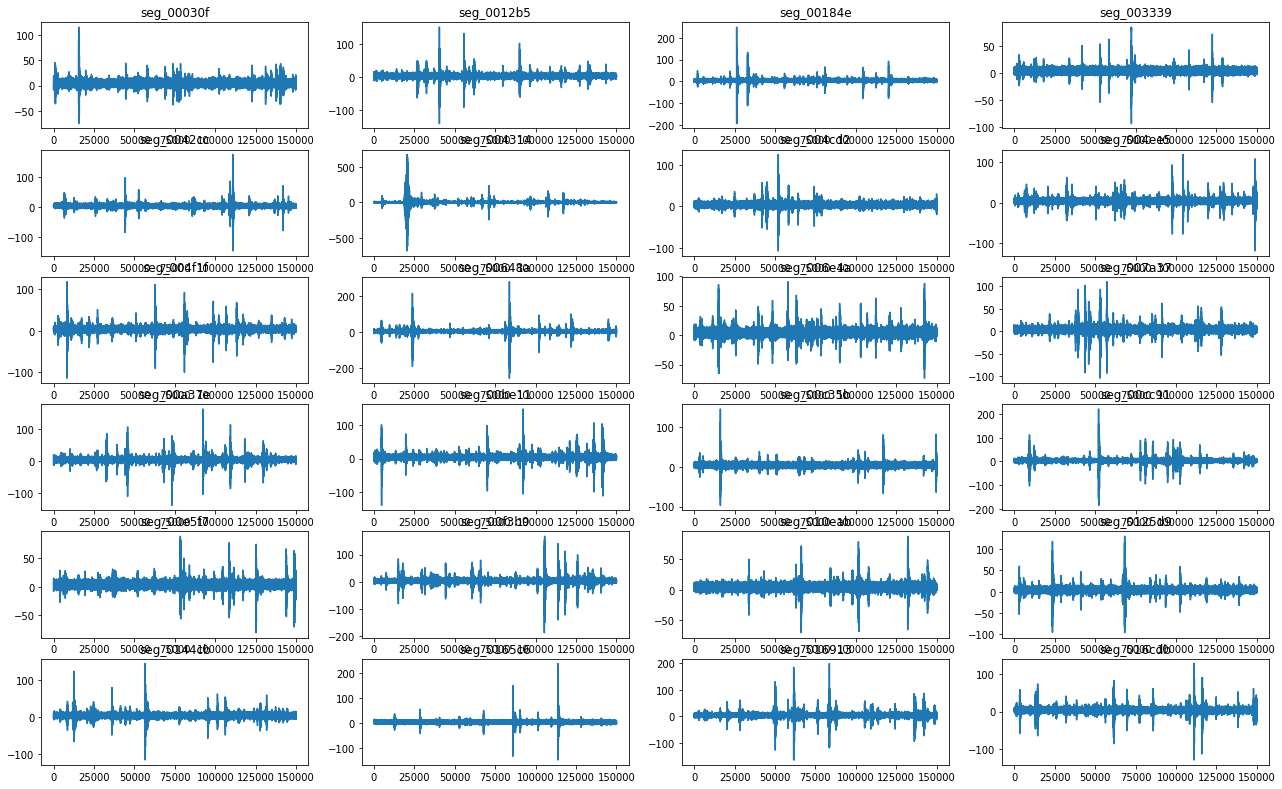

In [13]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)
plt.figure(figsize=(22, 16))

for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
        
    X_test.loc[seg_id, 'av_change_abs'] = np.mean(np.abs(np.diff(x)))
    X_test.loc[seg_id, 'av_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    X_test.loc[seg_id, 'abs_max'] = np.abs(x).max()
    X_test.loc[seg_id, 'abs_min'] = np.abs(x).min()
    
    X_test.loc[seg_id, 'std_first_50000'] = x[:50000].std()
    X_test.loc[seg_id, 'std_last_50000'] = x[-50000:].std()
    X_test.loc[seg_id, 'std_first_10000'] = x[:10000].std()
    X_test.loc[seg_id, 'std_last_10000'] = x[-10000:].std()
    
    X_test.loc[seg_id, 'avg_first_50000'] = x[:50000].mean()
    X_test.loc[seg_id, 'avg_last_50000'] = x[-50000:].mean()
    X_test.loc[seg_id, 'avg_first_10000'] = x[:10000].mean()
    X_test.loc[seg_id, 'avg_last_10000'] = x[-10000:].mean()
    
    X_test.loc[seg_id, 'min_first_50000'] = x[:50000].min()
    X_test.loc[seg_id, 'min_last_50000'] = x[-50000:].min()
    X_test.loc[seg_id, 'min_first_10000'] = x[:10000].min()
    X_test.loc[seg_id, 'min_last_10000'] = x[-10000:].min()
    
    X_test.loc[seg_id, 'max_first_50000'] = x[:50000].max()
    X_test.loc[seg_id, 'max_last_50000'] = x[-50000:].max()
    X_test.loc[seg_id, 'max_first_10000'] = x[:10000].max()
    X_test.loc[seg_id, 'max_last_10000'] = x[-10000:].max()
    
    X_test.loc[seg_id, 'freq_cross_first_50000'] = freq_from_crossings(x[:50000], fs)
    X_test.loc[seg_id, 'freq_cross_last_50000'] = freq_from_crossings(x[-50000:], fs)
    X_test.loc[seg_id, 'freq_cross_first_10000'] = freq_from_crossings(x[:10000], fs)
    X_test.loc[seg_id, 'freq_cross_last_10000'] = freq_from_crossings(x[-10000:], fs)
    
    if i < 24:
        plt.subplot(7, 4, i + 1)
        plt.plot(seg['acoustic_data'])
        plt.title(seg_id)

In [14]:
X_tr.head()

,ave,std,max,min,av_change_abs,av_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,...,min_first_10000,min_last_10000,max_first_50000,max_last_50000,max_first_10000,max_last_10000,freq_cross_first_50000,freq_cross_last_50000,freq_cross_first_10000,freq_cross_last_10000
0,4.884113333333334,5.101089126891323,104.0,-98.0,2.613217421449476,74836.577199220613693,104.0,0.0,6.488487003146419,3.664626773410902,...,-98.0,-16.0,104.0,30.0,104.0,26.0,235294.117647058825241,222222.222222222218988,231386.035526430147002,240963.855421688058414
1,4.725766666666667,6.588801819164257,181.0,-154.0,2.701524676831179,74891.736231905975728,181.0,0.0,7.305159645072789,5.493015569284325,...,-23.0,-24.0,181.0,111.0,29.0,29.0,234817.247885952820070,222664.015904611209407,213333.333333333343035,211161.387631976744160
2,4.906393333333333,6.967373808828945,140.0,-106.0,2.792605284035227,75099.224450501744286,140.0,0.0,6.104775408645269,8.603609576427791,...,-87.0,-71.0,97.0,140.0,97.0,95.0,231884.057971014495706,226567.768037766858470,240000.000000008731149,241206.030150751554174
3,4.902240000000000,6.922282112791032,197.0,-199.0,2.705618037453583,74933.991878648565034,199.0,0.0,6.238047094275579,5.652385375078384,...,-48.0,-36.0,75.0,84.0,75.0,35.0,235294.117647058825241,223880.597014901053626,230769.230769234796753,206388.206388207298005
4,4.908720000000000,7.301085852684289,145.0,-126.0,2.712478083187221,75010.016045975266024,145.0,0.0,5.323776277643530,7.694429122189637,...,-44.0,-126.0,93.0,128.0,57.0,128.0,215053.763440866518067,208695.652173939452041,210526.315789473679615,231884.057971014495706


In [15]:
X_test.head()

,ave,std,max,min,av_change_abs,av_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,...,min_first_10000,min_last_10000,max_first_50000,max_last_50000,max_first_10000,max_last_10000,freq_cross_first_50000,freq_cross_last_50000,freq_cross_first_10000,freq_cross_last_10000
seg_id,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.491780000000000,4.893673374701939,115.0,-75.0,2.609324062160415,75044.983541275520111,115.0,0.0,5.350397529754215,4.793827681467076,...,-36.0,-37.0,115.0,43.0,45.0,43.0,237623.762376237893477,244897.959183637110982,240240.240240245475434,265193.370165743166581
seg_0012b5,4.171153333333334,5.922819700375451,152.0,-140.0,2.672431149540997,74949.685652956031845,152.0,0.0,6.249452857682823,4.147520836162249,...,-12.0,-19.0,152.0,49.0,22.0,40.0,260162.601626016257796,238984.316654229944106,265193.370165743166581,246786.632390743179712
seg_00184e,4.610260000000000,6.946966920827151,248.0,-193.0,2.692197947986320,74997.632054261513986,248.0,0.0,9.793375065195859,5.225861226630497,...,-26.0,-8.0,248.0,92.0,49.0,19.0,232791.769148161314661,219703.574542276561260,234948.604992656590184,194331.983805670868605
seg_003339,4.531473333333333,4.114132889113924,85.0,-93.0,2.516930112867419,74997.954642264914582,93.0,0.0,3.664051054447795,3.480805049352807,...,-23.0,-7.0,51.0,72.0,34.0,15.0,216110.019646370841656,189723.320158080954570,219378.427787942200666,166956.521739130577771
seg_0042cc,4.128340000000000,5.797144312308719,177.0,-147.0,2.636957579717198,75075.108146992672118,177.0,0.0,5.321079585948700,7.486067361599146,...,-37.0,-79.0,99.0,177.0,49.0,72.0,242005.185825416643638,250434.782608689303743,250000.000000000000000,243902.439024388877442


In [16]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [17]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [18]:
def train_model(X=X_train_scaled, X_test=X_test_scaled, y=y_tr, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_tr.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_tr.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'rcv':
            model = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_absolute_error', cv=3)
            model.fit(X_train, y_train)
            print(model.alpha_)

            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train.values.ravel())
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

Fold 0 started at Sat Mar  2 16:20:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1004]	training's l1: 1.82145	valid_1's l1: 2.15782
Fold 1 started at Sat Mar  2 16:20:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1398]	training's l1: 1.73187	valid_1's l1: 2.09158
Fold 2 started at Sat Mar  2 16:20:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[987]	training's l1: 1.81411	valid_1's l1: 2.22115
Fold 3 started at Sat Mar  2 16:20:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[936]	training's l1: 1.8881	valid_1's l1: 1.98277
Fold 4 started at Sat Mar  2 16:20:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1110]	training's l1: 1.80916	valid_1's l1: 2.10845
CV mean score: 2.1124, std: 0.0789.


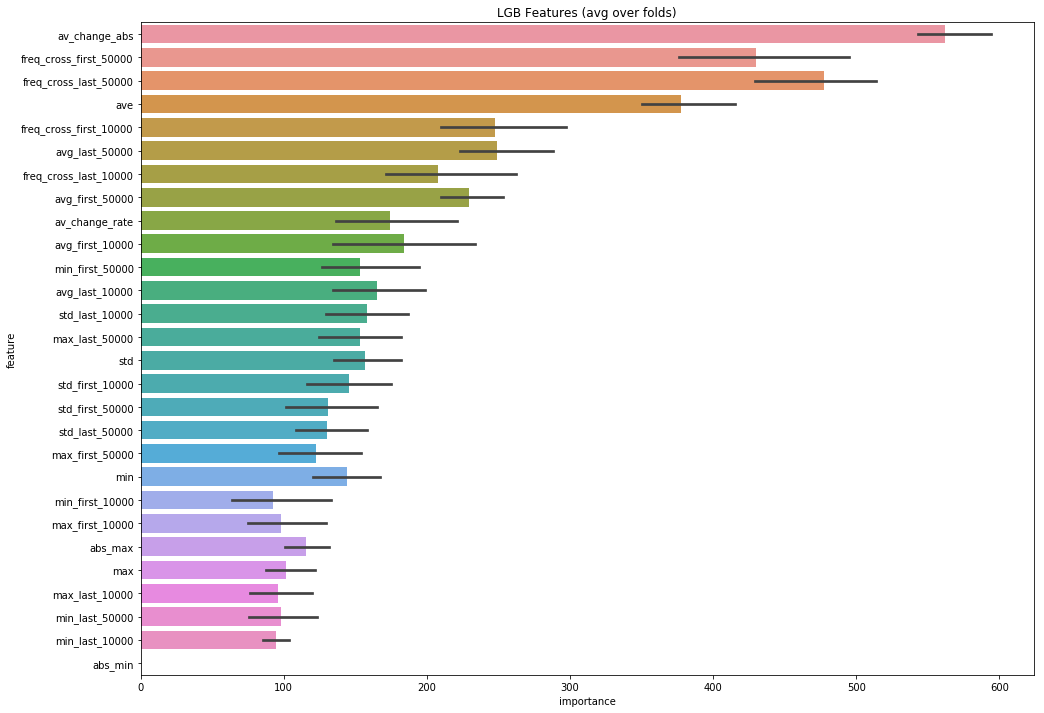

In [19]:
params = {'num_leaves': 54,
         'min_data_in_leaf': 79,
         'objective': 'huber',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         # "feature_fraction": 0.8354507676881442,
         "bagging_freq": 3,
         "bagging_fraction": 0.8126672064208567,
         "bagging_seed": 11,
         "metric": 'mae',
         "verbosity": -1,
         'reg_alpha': 1.1302650970728192,
         'reg_lambda': 0.3603427518866501
         }
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', plot_feature_importance=True)

In [20]:
xgb_params = {'eta': 0.04, 'max_depth': 10, 'subsample': 0.9, #'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': True, 'nthread': 4}
oof_xgb, prediction_xgb = train_model(params=xgb_params, model_type='xgb')

Fold 0 started at Sat Mar  2 16:20:54 2019
[0]	train-mae:4.98812	valid_data-mae:5.13174
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[84]	train-mae:0.65707	valid_data-mae:2.26413

Fold 1 started at Sat Mar  2 16:20:56 2019
[0]	train-mae:5.01382	valid_data-mae:5.02993
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[98]	train-mae:0.584286	valid_data-mae:2.15269

Fold 2 started at Sat Mar  2 16:20:57 2019
[0]	train-mae:5.00765	valid_data-mae:5.05628
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[76]	train-mae:0.688634	valid_data-mae:2.29784

Fold 3 started at Sat Mar  2 16:20:59 2019
[0]	train-

In [21]:
model = NuSVR(gamma='scale', nu=0.7, C=10.0)
oof_svr, prediction_svr = train_model(params=None, model_type='sklearn', model=model)

Fold 0 started at Sat Mar  2 16:21:03 2019
Fold 0. MAE: 2.1692.

Fold 1 started at Sat Mar  2 16:21:03 2019
Fold 1. MAE: 2.1061.

Fold 2 started at Sat Mar  2 16:21:04 2019
Fold 2. MAE: 2.2317.

Fold 3 started at Sat Mar  2 16:21:05 2019
Fold 3. MAE: 2.0000.

Fold 4 started at Sat Mar  2 16:21:06 2019
Fold 4. MAE: 2.1481.

CV mean score: 2.1310, std: 0.0770.


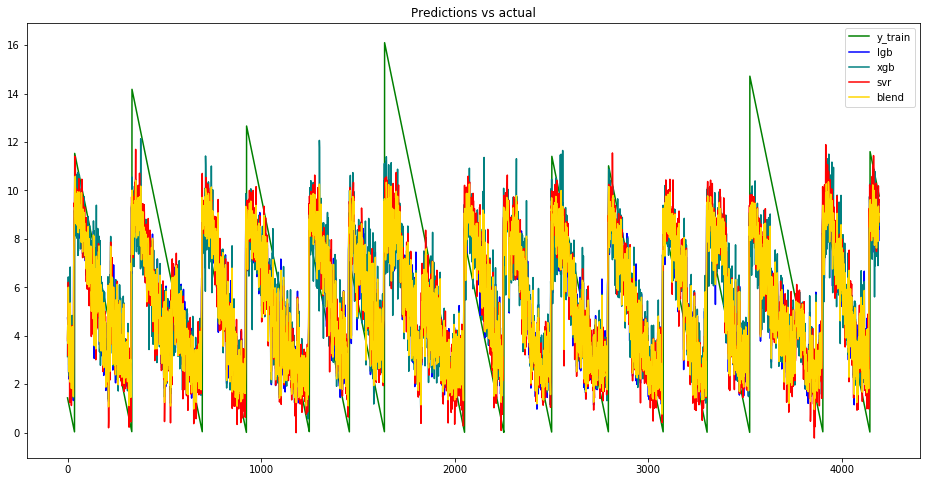

In [22]:
plt.figure(figsize=(16, 8))
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_lgb, color='b', label='lgb')
plt.plot(oof_xgb, color='teal', label='xgb')
plt.plot(oof_svr, color='red', label='svr')
plt.plot((oof_lgb + oof_xgb + oof_svr) / 3, color='gold', label='blend')
plt.legend();
plt.title('Predictions vs actual');

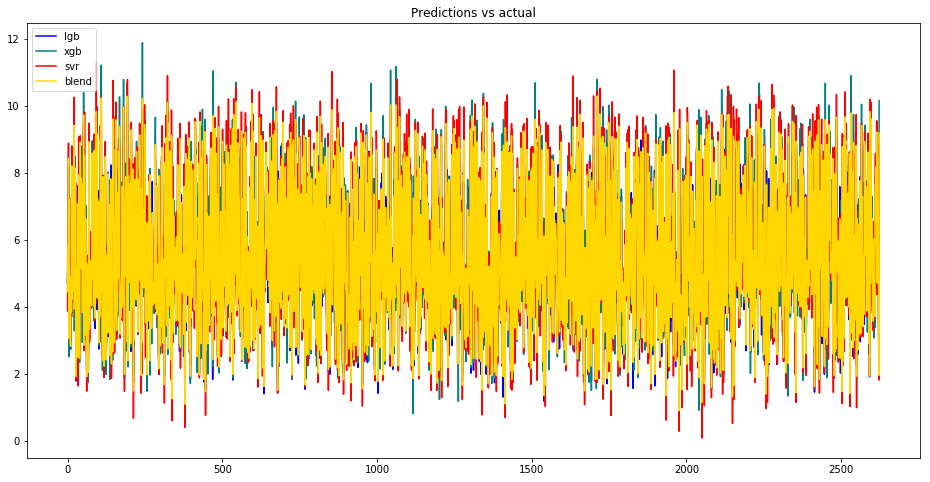

In [23]:
plt.figure(figsize=(16, 8))
plt.plot(prediction_lgb, color='b', label='lgb')
plt.plot(prediction_xgb, color='teal', label='xgb')
plt.plot(prediction_svr, color='red', label='svr')
plt.plot((prediction_lgb + prediction_xgb + prediction_svr) / 3, color='gold', label='blend')
plt.legend();
plt.title('Predictions vs actual');

In [24]:
submission['time_to_failure'] = (prediction_lgb + prediction_xgb + prediction_svr) / 3

In [25]:
submission.to_csv('../output/submission_rdg.csv')